In [1]:
%store -r df_calendar

In [2]:
import pandas as pd 

In [3]:
print("\nData types:")
print(df_calendar.dtypes)
print("\nMissing values:")
print(df_calendar.isnull().sum())


Data types:
listing_id          int64
date               object
available          object
price              object
adjusted_price    float64
minimum_nights    float64
maximum_nights    float64
dtype: object

Missing values:
listing_id              0
date                    0
available               0
price                   0
adjusted_price    5085865
minimum_nights         39
maximum_nights         39
dtype: int64


In [4]:
df_calendar_clean = df_calendar.drop('adjusted_price', axis=1)

In [5]:
# Remove $ and convert to float
df_calendar_clean['price'] = df_calendar_clean['price'].str.replace('$', '', regex=False)
df_calendar_clean['price'] = df_calendar_clean['price'].str.replace(',', '', regex=False)
df_calendar_clean['price'] = pd.to_numeric(df_calendar_clean['price'], errors='coerce')

print("\nSample prices after cleaning:")
print(df_calendar_clean['price'].head())
print(f"\nPrice stats:")
print(df_calendar_clean['price'].describe())


Sample prices after cleaning:
0    51.0
1    51.0
2    51.0
3    51.0
4    51.0
Name: price, dtype: float64

Price stats:
count    5.085865e+06
mean     1.540131e+02
std      4.361455e+02
min      0.000000e+00
25%      5.400000e+01
50%      8.700000e+01
75%      1.400000e+02
max      1.000000e+04
Name: price, dtype: float64


In [6]:
# Convert date column
print("Sample dates before conversion:")
print(df_calendar_clean['date'].head())
print(f"Date data type: {df_calendar_clean['date'].dtype}")

# Convert to datetime
df_calendar_clean['date'] = pd.to_datetime(df_calendar_clean['date'])

print("\nSample dates after conversion:")
print(df_calendar_clean['date'].head())
print(f"New date data type: {df_calendar_clean['date'].dtype}")
print(f"Date range: {df_calendar_clean['date'].min()} to {df_calendar_clean['date'].max()}")

Sample dates before conversion:
0    2025-03-16
1    2025-03-17
2    2025-03-18
3    2025-03-19
4    2025-03-20
Name: date, dtype: object
Date data type: object

Sample dates after conversion:
0   2025-03-16
1   2025-03-17
2   2025-03-18
3   2025-03-19
4   2025-03-20
Name: date, dtype: datetime64[ns]
New date data type: datetime64[ns]
Date range: 2025-03-15 00:00:00 to 2026-03-16 00:00:00


In [7]:
print("Available values before conversion:")
print(df_calendar_clean['available'].value_counts())


Available values before conversion:
available
f    3228016
t    1857849
Name: count, dtype: int64


In [8]:
df_calendar_clean['available'] = df_calendar_clean['available'].map({'t': True, 'f': False})

In [9]:
print("\nAvailable values after conversion:")
print(df_calendar_clean['available'].value_counts())


Available values after conversion:
available
False    3228016
True     1857849
Name: count, dtype: int64


In [10]:
print("Missing values in nights columns:")
print(f"minimum_nights: {df_calendar_clean['minimum_nights'].isnull().sum()}")
print(f"maximum_nights: {df_calendar_clean['maximum_nights'].isnull().sum()}")


Missing values in nights columns:
minimum_nights: 39
maximum_nights: 39


In [11]:
# Look at some examples
print("\nRows with missing nights:")
missing_nights = df_calendar_clean[df_calendar_clean['minimum_nights'].isnull()]
print(missing_nights.head())


Rows with missing nights:
         listing_id       date  available  price  minimum_nights  \
9438         231220 2025-03-15      False   32.0             NaN   
1068408    17077519 2025-03-15       True  229.0             NaN   
1195722    18846314 2025-03-15      False  200.0             NaN   
1340223    21560531 2025-03-15      False   86.0             NaN   
1458091    23731129 2025-03-15      False  199.0             NaN   

         maximum_nights  
9438                NaN  
1068408             NaN  
1195722             NaN  
1340223             NaN  
1458091             NaN  


In [12]:
print("Dates with missing nights:")
print(df_calendar_clean[df_calendar_clean['minimum_nights'].isnull()]['date'].value_counts())

# Check how many total listings have data for 2025-03-15
print(f"\nTotal entries for 2025-03-15: {len(df_calendar_clean[df_calendar_clean['date'] == '2025-03-15'])}")
print(f"Missing nights on 2025-03-15: {len(missing_nights)}")

Dates with missing nights:
date
2025-03-15    39
Name: count, dtype: int64

Total entries for 2025-03-15: 3875
Missing nights on 2025-03-15: 39


In [13]:
# Fill missing nights with each listing's typical values
print("Filling missing nights with listing-specific medians...")

# Calculate median nights for each listing
listing_medians = df_calendar_clean.groupby('listing_id')[['minimum_nights', 'maximum_nights']].median()

# Fill missing values
for idx in df_calendar_clean[df_calendar_clean['minimum_nights'].isnull()].index:
    listing_id = df_calendar_clean.loc[idx, 'listing_id']
    
    if listing_id in listing_medians.index:
        df_calendar_clean.loc[idx, 'minimum_nights'] = listing_medians.loc[listing_id, 'minimum_nights']
        df_calendar_clean.loc[idx, 'maximum_nights'] = listing_medians.loc[listing_id, 'maximum_nights']

# Verify the fix
print(f"Missing minimum_nights after fix: {df_calendar_clean['minimum_nights'].isnull().sum()}")
print(f"Missing maximum_nights after fix: {df_calendar_clean['maximum_nights'].isnull().sum()}")

Filling missing nights with listing-specific medians...
Missing minimum_nights after fix: 0
Missing maximum_nights after fix: 0


In [14]:
zero_prices = df_calendar_clean[df_calendar_clean['price'] == 0]
print(f"Number of entries with $0 price: {len(zero_prices)}")
print(f"Percentage of total data: {len(zero_prices)/len(df_calendar_clean)*100:.2f}%")

print("\nSample of zero price entries:")
print(zero_prices.head(10))

print("\nAre zero prices correlated with availability?")
print(zero_prices['available'].value_counts())
print(f"% of zero prices that are unavailable: {(~zero_prices['available']).mean()*100:.1f}%")

print("\nUnique listings with zero prices:")
print(f"Number of unique listings: {zero_prices['listing_id'].nunique()}")

print("\nDate distribution of zero prices:")
print(zero_prices['date'].dt.date.value_counts().head(10))

Number of entries with $0 price: 365
Percentage of total data: 0.01%

Sample of zero price entries:
         listing_id       date  available  price  minimum_nights  \
1660891    28175257 2025-03-16       True    0.0             1.0   
1660892    28175257 2025-03-17       True    0.0             1.0   
1660893    28175257 2025-03-18      False    0.0             1.0   
1660894    28175257 2025-03-19       True    0.0             1.0   
1660895    28175257 2025-03-20       True    0.0             1.0   
1660896    28175257 2025-03-21       True    0.0             1.0   
1660897    28175257 2025-03-22       True    0.0             1.0   
1660898    28175257 2025-03-23       True    0.0             1.0   
1660899    28175257 2025-03-24       True    0.0             1.0   
1660900    28175257 2025-03-25      False    0.0             1.0   

         maximum_nights  
1660891          1125.0  
1660892          1125.0  
1660893          1125.0  
1660894          1125.0  
1660895          1125

In [15]:
df_calendar_cleaned = df_calendar_clean[df_calendar_clean['listing_id'] != 28175257].copy()

In [16]:
# Final validation
print("=== CALENDAR DATA CLEANING SUMMARY ===")
print(f"Final shape: {df_calendar_cleaned.shape}")
print(f"Columns: {df_calendar_cleaned.columns.tolist()}")
print("\nData types after cleaning:")
print(df_calendar_cleaned.dtypes)
print("\nMissing values after cleaning:")
print(df_calendar_cleaned.isnull().sum())
print("\nSample of cleaned data:")
print(df_calendar_cleaned.head())
print(f"\nPrice range: ${df_calendar_cleaned['price'].min():.2f} - ${df_calendar_cleaned['price'].max():.2f}")
print(f"Date range: {df_calendar_cleaned['date'].min().date()} to {df_calendar_cleaned['date'].max().date()}")
print(f"Available vs Not Available:")
print(df_calendar_cleaned['available'].value_counts())

=== CALENDAR DATA CLEANING SUMMARY ===
Final shape: (5085500, 6)
Columns: ['listing_id', 'date', 'available', 'price', 'minimum_nights', 'maximum_nights']

Data types after cleaning:
listing_id                 int64
date              datetime64[ns]
available                   bool
price                    float64
minimum_nights           float64
maximum_nights           float64
dtype: object

Missing values after cleaning:
listing_id        0
date              0
available         0
price             0
minimum_nights    0
maximum_nights    0
dtype: int64

Sample of cleaned data:
   listing_id       date  available  price  minimum_nights  maximum_nights
0      214518 2025-03-16       True   51.0             3.0            21.0
1      214518 2025-03-17       True   51.0             3.0            21.0
2      214518 2025-03-18       True   51.0             3.0            21.0
3      214518 2025-03-19       True   51.0             3.0            21.0
4      214518 2025-03-20       True   51

In [20]:
MAX_CAP = 365    
MIN_CAP = 90     

# 2. Cap the values
df_calendar_cleaned['maximum_nights'] = df_calendar_cleaned['maximum_nights'].clip(upper=MAX_CAP)
df_calendar_cleaned['minimum_nights'] = df_calendar_cleaned['minimum_nights'].clip(upper=MIN_CAP)

# 3. Fix any remaining cases where minimum > maximum
mask = df_calendar_cleaned['minimum_nights'] > df_calendar_cleaned['maximum_nights']
df_calendar_cleaned.loc[mask, 'minimum_nights'] = df_calendar_cleaned.loc[mask, 'maximum_nights']

In [22]:
Q1 = df_calendar_cleaned['price'].quantile(0.25)
Q3 = df_calendar_cleaned['price'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"IQR range: [{Q1:.2f}, {Q3:.2f}] → bounds: [{lower_bound:.2f}, {upper_bound:.2f}]")


IQR range: [54.00, 140.00] → bounds: [-75.00, 269.00]


In [25]:
upper_bound = 269.0
high_outliers = df_calendar_cleaned[df_calendar_cleaned['price'] > upper_bound]

count = len(high_outliers)
pct   = count / len(df_calendar_cleaned) * 100

print(f"Listings > ${upper_bound}: {count} rows ({pct:.2f}% of total)")


Listings > $269.0: 453630 rows (8.92% of total)


In [27]:
listing_stats = (
    high_outliers
    .groupby('listing_id')['price']
    .agg(days_count='count')
    .reset_index()
)

dist = listing_stats['days_count'].value_counts().sort_index()
print("Days above $269 → # of listings")
print(dist)


Days above $269 → # of listings
days_count
350      33
351      22
365    1182
366       8
Name: count, dtype: int64


In [28]:
fixed = high_outliers.groupby('listing_id')['price'].first()
top10 = fixed.value_counts().sort_values(ascending=False).head(10)
print("Top 10 price levels → # of listings")
print(top10)


Top 10 price levels → # of listings
price
999.0     189
300.0     141
1000.0    113
500.0     104
350.0      70
400.0      37
280.0      35
299.0      27
450.0      22
290.0      18
Name: count, dtype: int64


In [29]:
import numpy as np
percentiles = np.percentile(fixed.values, [0,5,25,50,75,90,95,99,100])
labels = ['0th','5th','25th','50th','75th','90th','95th','99th','100th']
for lab, val in zip(labels, percentiles):
    print(f"{lab} percentile: ${val:.2f}")


0th percentile: $270.00
5th percentile: $280.00
25th percentile: $315.00
50th percentile: $499.00
75th percentile: $999.00
90th percentile: $1000.00
95th percentile: $1000.00
99th percentile: $8952.48
100th percentile: $10000.00


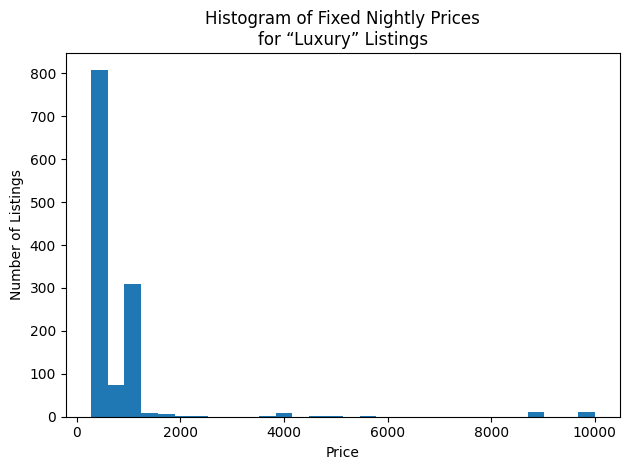

In [30]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(fixed.values, bins=30)
plt.title('Histogram of Fixed Nightly Prices\nfor “Luxury” Listings')
plt.xlabel('Price')
plt.ylabel('Number of Listings')
plt.tight_layout()
plt.show()


In [33]:
# 1. Filter to the high-price rows
high1500 = df_calendar_cleaned[df_calendar_cleaned['price'] > 1000]

# 2. Group by listing & price to get total days and booked days
booking_stats = (
    high1500
      .groupby(['listing_id','price'])
      .agg(
          days_total = ('date','count'),
          days_booked = ('available', lambda x: (~x).sum())
      )
      .reset_index()
)

# 3. Compute percent booked
booking_stats['pct_booked'] = (
    booking_stats['days_booked'] / booking_stats['days_total'] * 100
)

# 4. Sort by pct_booked (or days_booked) to see which ultra-luxury homes actually fill up
booking_stats = booking_stats.sort_values(
    by=['pct_booked','days_booked'], ascending=False
)

# 5. Inspect
print(booking_stats)   


             listing_id    price  days_total  days_booked  pct_booked
4              14201780   5000.0         365          365  100.000000
15             51936436  10000.0         365          365  100.000000
34  1234530954609092050   9999.0         365          327   89.589041
33  1234483210719889178   9999.0         365          293   80.273973
28  1234472636497962021   9999.0         365          289   79.178082
32  1234483190089885723   9999.0         365          287   78.630137
9              20109066   9999.0         365          286   78.356164
13             39877586   1500.0         365          277   75.890411
0               2860420   2500.0         365          276   75.616438
25  1213112096582667346   9000.0         365          250   68.493151
21  1162854339540261066   1750.0         365          240   65.753425
26  1221807351062027376   1180.0         365          236   64.657534
23  1184018203650802870   5750.0         366          220   60.109290
22  1163589720186876

In [34]:
invalid_ids = booking_stats.loc[booking_stats.pct_booked < 1, 'listing_id']
df_calendar_cleaned = df_calendar_cleaned.loc[
    ~df_calendar_cleaned['listing_id'].isin(invalid_ids)
].copy()

In [44]:
high_counts = (
    df_calendar_cleaned[df_calendar_cleaned['price'] > 1000]
      .groupby('listing_id')
      .size()
)

# require at least 350 such days
luxury_ids = high_counts[high_counts >= 350].index

# 3. Flag them
df_calendar_cleaned['is_luxury_listing'] = (
    df_calendar_cleaned['listing_id'].isin(luxury_ids)
)

# 4. Sanity check
print("Rows remaining:                 ", df_calendar_cleaned.shape[0])
print("Distinct listings left:         ", df_calendar_cleaned['listing_id'].nunique())
print("Distinct listings flagged lux:", df_calendar_cleaned.loc[df_calendar_cleaned['is_luxury_listing'], 'listing_id'].nunique())


Rows remaining:                  5080390
Distinct listings left:          13921
Distinct listings flagged lux: 44


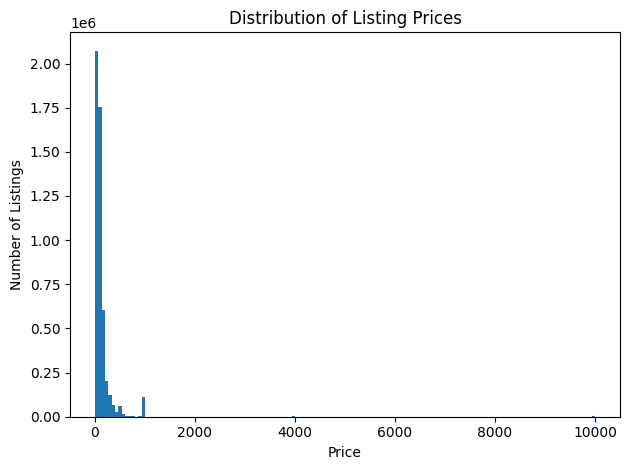

In [46]:
plt.figure()
plt.hist(df_calendar_cleaned['price'], bins=150)
plt.xlabel('Price')
plt.ylabel('Number of Listings')
plt.title('Distribution of Listing Prices')
plt.tight_layout()
plt.show()

In [47]:
%store df_calendar_cleaned

Stored 'df_calendar_cleaned' (DataFrame)
